In [1]:
import numpy as np
from movement_primitives.dmp import DMP
from movement_primitives.dmp._dmp import *
import matplotlib.pyplot as plt

import sys
import torch

folder_path = '../models/'
if folder_path not in sys.path:
    sys.path.append(folder_path)

folder_path = '../data/'
if folder_path not in sys.path:
    sys.path.append(folder_path)

from pemp import PEMP
from cnmp import CNMP

from data_generators import *
from positional_encoders import *
from plotters import *

torch.set_float32_matmul_precision('high')

def get_free_gpu():
    gpu_util = []
    for i in range(torch.cuda.device_count()):
        torch.cuda.set_device(i)  # Switch GPU
#        gpu_util.append((i, torch.cuda.memory_stats()['reserved_bytes.all.current'] / (1024 ** 2)))
        gpu_util.append((i, torch.cuda.utilization()))
    gpu_util.sort(key=lambda x: x[1])
    return gpu_util[0][0]

if torch.cuda.is_available():
    available_gpu = get_free_gpu()
    if available_gpu == 0:
        device = torch.device("cuda:0")
    else:
        device = torch.device(f"cuda:{available_gpu}")
else:
    device = torch.device("cpu")

print("Device :", device)

Device : cuda:0


In [2]:
dx, dy, dg, dpe = 1, 1, 0, 10
num_demos, num_test = 8, 2
num_trajs = num_demos + num_test
t_steps = 200
n_max, m_max = 10, 10
num_peaks = 2

# x, y, pp = n_peaks(1, num_trajs, 0.1)
x, y, pp = n_peaks(num_peaks, num_trajs, 0.065)
print(x.shape, y.shape)

# test_ids = []
# while len(test_ids) < num_test:
#     test_id = np.random.choice(np.arange(num_trajs), 1)
#     # continue if pp[test_id] is either smallest or largest value
#     # append to test_id otherwise
#     if (pp[test_id, 0] == torch.max(pp[:, 0]) or pp[test_id, 0] == torch.min(pp[:, 0])):
#         continue
#     else:
#         if test_id not in test_ids:
#             test_ids.append(test_id)

# train_ids = np.setdiff1d(np.arange(num_trajs), test_ids)
# test_ids = torch.tensor(test_ids).squeeze(-1)
# train_ids = torch.from_numpy(train_ids)

# test_cond_ind = (pp[test_ids] * 200).int()

# y_train = y[train_ids].clone()
# y_test = y[test_ids].clone()

# x_train = x[train_ids].clone()
# x_test = x[test_ids].clone()

# # Print shapes
# print(f"x_train shape: {x_train.shape}, y_train shape: {y_train.shape}")
# print(f"x_test shape: {x_test.shape}, y_test shape: {y_test.shape}")

torch.Size([10, 200, 1]) torch.Size([10, 200, 1])


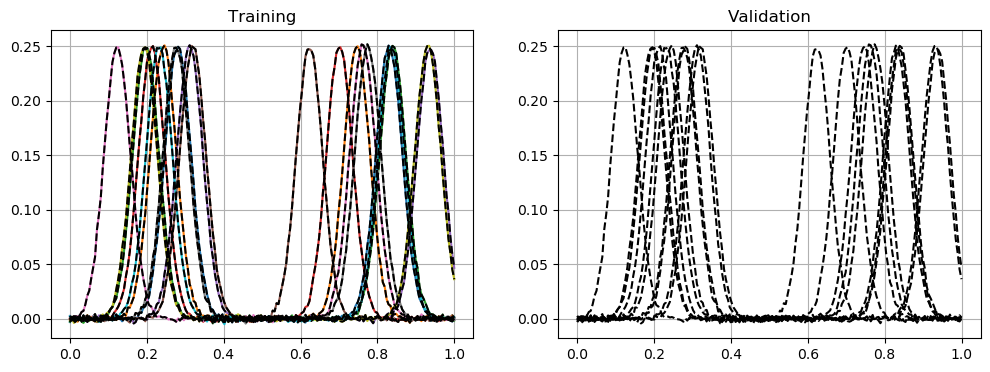

In [3]:
plot_train_val(num_trajs, x, y, num_trajs, x, y)

In [4]:
from copy import deepcopy

dt = 1/t_steps
dz = dx

d_ = DMP(n_dims=dy, n_weights_per_dim=6, dt=dt)

forcing_terms = torch.zeros((num_trajs, t_steps))
phases = torch.zeros((num_trajs, t_steps))

for i in range(num_trajs):
    d = deepcopy(d_)
    d.imitate(x[i, :, 0].numpy(), y[i].numpy())
    
    for j, t in enumerate(np.arange(0, 1, dt)):
        z = d.forcing_term.phase(t)  # Calculate the phase
        phases[i, j] = z
        forcing_terms[i, j] = torch.from_numpy(d.forcing_term.forcing_term(z).squeeze())

y_train, y_test = forcing_terms[:num_demos], forcing_terms[num_demos:]
x_train, x_test = phases[:num_demos], phases[num_demos:]

y_train, y_test = (y_train/1000).unsqueeze(-1).to(device), (y_test/1000).unsqueeze(-1).to(device)
x_train, x_test = x_train.unsqueeze(-1).to(device), x_test.unsqueeze(-1).to(device)

print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

torch.Size([8, 200, 1]) torch.Size([8, 200, 1])
torch.Size([2, 200, 1]) torch.Size([2, 200, 1])


In [5]:
batch_size = 1

enc_dims = [64,64]
dec_dims = [64,64]

pemp_ = PEMP(input_dim=dpe+dg, output_dim=dy, n_max=n_max, m_max=m_max, encoder_hidden_dims=enc_dims, decoder_hidden_dims=dec_dims, batch_size=batch_size, device=device)
optimizer = torch.optim.Adam(lr=3e-4, params=pemp_.parameters())

pemp_1 = PEMP(input_dim=dpe+dg, output_dim=dy, n_max=n_max, m_max=m_max, encoder_hidden_dims=enc_dims, decoder_hidden_dims=dec_dims, batch_size=batch_size, device=device)
optimizer1 = torch.optim.Adam(lr=3e-4, params=pemp_1.parameters())

cnmp_ = CNMP(input_dim=dx+dg, output_dim=dy, n_max=n_max, m_max=m_max, encoder_hidden_dims=enc_dims, decoder_hidden_dims=dec_dims, batch_size=batch_size, device=device)
optimizer_cnmp = torch.optim.Adam(lr=3e-4, params=cnmp_.parameters())

pytorch_total_params = sum(p.numel() for p in pemp_.parameters())
print('PEMP: ', pytorch_total_params)
pytorch_total_params = sum(p.numel() for p in cnmp_.parameters())
print('CNMP: ', pytorch_total_params)


if torch.__version__ >= "2.0":
    pemp, pemp1, cnmp = torch.compile(pemp_), torch.compile(pemp_1), torch.compile(cnmp_)
else:
    pemp, pemp1, cnmp = pemp_, pemp_1, cnmp_

PEMP:  9858
CNMP:  8706


In [6]:
d_model = dpe
pe_code = 0
pe = (pes[pe_code]() / d_model).to(device)

pe_code = 1
pe1 = (pes[pe_code]() / d_model).to(device)

In [7]:
dpe_aug = dpe + dg  # dg for gamma (peak_positions)
dpe_aug_cnmp = dx + dg

obs = torch.zeros((batch_size, n_max, dpe_aug+dy), dtype=torch.float32, device=device)
obs1 = torch.zeros((batch_size, n_max, dpe_aug+dy), dtype=torch.float32, device=device)
obs_cnmp = torch.zeros((batch_size, n_max, dpe_aug_cnmp+dy), dtype=torch.float32, device=device)
tar_x = torch.zeros((batch_size, m_max, dpe_aug), dtype=torch.float32, device=device)
tar_x1 = torch.zeros((batch_size, m_max, dpe_aug), dtype=torch.float32, device=device)
tar_x_cnmp = torch.zeros((batch_size, m_max, dpe_aug_cnmp), dtype=torch.float32, device=device)
tar_y = torch.zeros((batch_size, m_max, dy), dtype=torch.float32, device=device)
obs_mask = torch.zeros((batch_size, n_max), dtype=torch.bool, device=device)
tar_mask = torch.zeros((batch_size, m_max), dtype=torch.bool, device=device)

def prepare_masked_batch(t: list, traj_ids: list):
    obs.fill_(0)
    tar_x.fill_(0)
    tar_y.fill_(0)
    obs_mask.fill_(False)
    tar_mask.fill_(False)

    obs_cnmp.fill_(0)
    tar_x_cnmp.fill_(0)

    obs1.fill_(0)
    tar_x1.fill_(0)

    for i, traj_id in enumerate(traj_ids):
        traj = t[traj_id]

        n = torch.randint(5, n_max, (1,)).item()
        m = torch.randint(1, m_max, (1,)).item()

        permuted_ids = torch.randperm(t_steps)
        n_ids = permuted_ids[:n]
        m_ids = permuted_ids[n:n+m]

        # pe_n_ids = ((1-x_train[traj_id, n_ids])*t_steps).int()  # (1-phase) * t_steps
        # pe_m_ids = ((1-x_train[traj_id, m_ids])*t_steps).int()
        
        obs[i, :n, :dpe] = pe[n_ids] # PE(t)
        obs[i, :n, dpe_aug:] = traj[n_ids]  # SM(t)
        obs_mask[i, :n] = True
        
        tar_x[i, :m, :dpe] = pe[m_ids]
        tar_y[i, :m] = traj[m_ids]
        tar_mask[i, :m] = True

        obs1[i, :n, :dpe] = pe1[n_ids] # PE(t)
        obs1[i, :n, dpe_aug:] = traj[n_ids]  # SM(t)

        tar_x1[i, :m, :dpe] = pe1[m_ids]

        obs_cnmp[i, :n, :dx] = x_train[traj_id, n_ids]
        obs_cnmp[i, :n, dpe_aug_cnmp:] = traj[n_ids]  # SM(t)
        tar_x_cnmp[i, :m, :dx] = x_train[traj_id, m_ids]

val_obs = torch.zeros((batch_size, n_max, dpe_aug+dy), dtype=torch.float32, device=device)
val_obs1 = torch.zeros((batch_size, n_max, dpe_aug+dy), dtype=torch.float32, device=device)
val_obs_cnmp = torch.zeros((batch_size, n_max, dpe_aug_cnmp+dy), dtype=torch.float32, device=device)
val_tar_x = torch.zeros((batch_size, t_steps, dpe_aug), dtype=torch.float32, device=device)
val_tar_x1 = torch.zeros((batch_size, t_steps, dpe_aug), dtype=torch.float32, device=device)
val_tar_x_cnmp = torch.zeros((batch_size, t_steps, dpe_aug_cnmp), dtype=torch.float32, device=device)
val_tar_y = torch.zeros((batch_size, t_steps, dy), dtype=torch.float32, device=device)
val_obs_mask = torch.zeros((batch_size, n_max), dtype=torch.bool, device=device)

def prepare_masked_val_batch(t: list, traj_ids: list, fixed_ind=None):
    val_obs.fill_(0)
    val_tar_x.fill_(0)
    val_tar_y.fill_(0)
    val_obs_mask.fill_(False)

    val_obs_cnmp.fill_(0)
    val_tar_x_cnmp.fill_(0)

    val_obs1.fill_(0)
    val_tar_x1.fill_(0)

    for i, traj_id in enumerate(traj_ids):
        traj = t[traj_id]

        n = num_peaks #torch.randint(5, n_max, (1,)).item()

        permuted_ids = torch.randperm(t_steps)
        n_ids = permuted_ids[:n]
        m_ids = torch.arange(t_steps)
        if fixed_ind != None:
            for p in range(n):
                n_ids[p] = fixed_ind[i, p]
            # n_ids[-1] = fixed_ind[i]

        # pe_n_ids = ((1-x_train[traj_id, n_ids])*t_steps).int()  # (1-phase) * t_steps
        
        val_obs[i, :n, :dpe] = pe[n_ids]
        val_obs[i, :n, dpe_aug:] = traj[n_ids]
        val_obs_mask[i, :n] = True

        val_obs1[i, :n, :dpe] = pe1[n_ids]
        val_obs1[i, :n, dpe_aug:] = traj[n_ids]
        
        val_tar_x[i, :, :dpe] = pe
        val_tar_y[i] = traj[m_ids]

        val_tar_x1[i, :, :dpe] = pe1

        val_obs_cnmp[i, :n, :dx] = x_test[traj_id, n_ids]
        val_obs_cnmp[i, :n, dpe_aug_cnmp:] = traj[n_ids]

        val_tar_x_cnmp[i, :, :dx] = x_test[traj_id]

In [8]:
import time
import os

pose_code = ('no' if dpe_aug==dpe else 'with') + '_pos'
arch_code = str(num_demos) + '_' + str(num_test) + '_'
for i in enc_dims:
    arch_code += str(i) + '_'
arch_code = arch_code[:-1]

timestamp = int(time.time())
root_folder = f'../outputs/force/comparison/{num_peaks}_peak/{pose_code}/{arch_code}/bs_{batch_size}/{str(timestamp)}/'

if not os.path.exists(root_folder):
    os.makedirs(root_folder)

if not os.path.exists(f'{root_folder}saved_models/'):
    os.makedirs(f'{root_folder}saved_models/')

img_folder = f'{root_folder}img/'
if not os.path.exists(img_folder):
    os.makedirs(img_folder)

torch.save(y_train, f'{root_folder}y.pt')

epochs = 500_000
epoch_iter = num_demos // batch_size
v_epoch_iter = num_test//batch_size
avg_loss, avg_loss1, avg_loss_cnmp = 0, 0, 0
loss_report_interval = 500
val_per_epoch = 1000
min_val_loss, min_val_loss1, min_val_loss_cnmp = 1000000, 1000000, 1000000
mse_loss = torch.nn.MSELoss()

plot_test = True

l, l1, l_cnmp = [], [], []

for epoch in range(epochs):
    epoch_loss, epoch_loss1, epoch_loss_cnmp = 0, 0, 0

    traj_ids = torch.randperm(num_demos)[:batch_size * epoch_iter].chunk(epoch_iter)

    for i in range(epoch_iter):
        prepare_masked_batch(y_train, traj_ids[i])

        optimizer.zero_grad()        
        pred = pemp(obs, tar_x, obs_mask)
        loss = pemp.loss(pred, tar_y, tar_mask)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

        optimizer1.zero_grad()        
        pred1 = pemp1(obs1, tar_x1, obs_mask)
        loss1 = pemp1.loss(pred1, tar_y, tar_mask)
        loss1.backward()
        optimizer1.step()

        epoch_loss1 += loss1.item()

        optimizer_cnmp.zero_grad()        
        pred_cnmp = cnmp(obs_cnmp, tar_x_cnmp, obs_mask)
        loss_cnmp = cnmp.loss(pred_cnmp, tar_y, tar_mask)
        loss_cnmp.backward()
        optimizer_cnmp.step()

        epoch_loss_cnmp += loss_cnmp.item()

    if epoch % val_per_epoch == 0 and epoch > 0:
        with torch.no_grad():
            v_traj_ids = torch.randperm(num_test)[:batch_size*v_epoch_iter].chunk(v_epoch_iter)
            val_loss, val_loss1, val_loss_cnmp = 0, 0, 0

            for j in range(v_epoch_iter):
                prepare_masked_val_batch(y_test, v_traj_ids[j])
                pred = pemp.val(val_obs, val_tar_x, val_obs_mask)
                if plot_test:
                    for k in range(batch_size):
                        plt.plot(val_tar_y[k, :, 0].cpu().numpy(), label=f"True {k}")
                        plt.plot(pred[k, :, 0].cpu().numpy(), label=f"Pred {k}")
                        
                        plt.legend()
                        plt.savefig(f'{img_folder}{epoch}_PEMP_{j}_{k}.png')
                        plt.clf()
                val_loss += mse_loss(pred[:, :, :pemp.output_dim], val_tar_y).item()

                pred1 = pemp1.val(val_obs1, val_tar_x1, val_obs_mask)
                if plot_test:
                    for k in range(batch_size):
                        plt.plot(val_tar_y[k, :, 0].cpu().numpy(), label=f"True {k}")
                        plt.plot(pred1[k, :, 0].cpu().numpy(), label=f"Pred {k}")
                        
                        plt.legend()
                        plt.savefig(f'{img_folder}{epoch}_PEMP1_{j}_{k}.png')
                        plt.clf()
                val_loss1 += mse_loss(pred1[:, :, :pemp1.output_dim], val_tar_y).item()

                pred_cnmp = cnmp.val(val_obs_cnmp, val_tar_x_cnmp, val_obs_mask)
                if plot_test:
                    for k in range(batch_size):
                        plt.plot(val_tar_y[k, :, 0].cpu().numpy(), label=f"True {k}")
                        plt.plot(pred_cnmp[k, :, 0].cpu().numpy(), label=f"Pred {k}")
                        
                        plt.legend()
                        plt.savefig(f'{img_folder}{epoch}_CNMP_{j}_{k}.png')
                        plt.clf()
                val_loss_cnmp += mse_loss(pred_cnmp[:, :, :cnmp.output_dim], val_tar_y).item()
            
            val_loss /= v_epoch_iter
            val_loss1 /= v_epoch_iter
            val_loss_cnmp /= v_epoch_iter
                
            if val_loss < min_val_loss:
                min_val_loss = val_loss
                print(f'PEMP New best: {min_val_loss}', f'CNMP best: {min_val_loss_cnmp}')
                torch.save(pemp_.state_dict(), f'{root_folder}saved_models/pemp.pt')

            if val_loss1 < min_val_loss1:
                min_val_loss1 = val_loss1
                # print(f'PEMP1 New best: {min_val_loss1}')
                torch.save(pemp_1.state_dict(), f'{root_folder}saved_models/pemp1.pt')

            if val_loss_cnmp < min_val_loss_cnmp:
                min_val_loss_cnmp = val_loss_cnmp
                print(f'CNMP New best: {min_val_loss_cnmp}', f'PEMP best: {min_val_loss}')
                torch.save(cnmp_.state_dict(), f'{root_folder}saved_models/cnmp.pt')

    epoch_loss /= epoch_iter
    epoch_loss1 /= epoch_iter
    epoch_loss_cnmp /= epoch_iter

    avg_loss += epoch_loss
    avg_loss1 += epoch_loss1
    avg_loss_cnmp += epoch_loss_cnmp

    l.append(epoch_loss)
    l1.append(epoch_loss1)
    l_cnmp.append(epoch_loss_cnmp)

    if epoch % loss_report_interval == 0:
        print("Epoch: {}, PEMP Loss: {}, PEMP1 Loss: {}, CNMP Loss: {}".format(epoch, avg_loss/loss_report_interval, avg_loss1/loss_report_interval, avg_loss_cnmp/loss_report_interval))
        avg_loss, avg_loss1, avg_loss_cnmp = 0, 0, 0

Epoch: 0, PEMP Loss: 0.0010122744366526603, PEMP1 Loss: 0.0009855405911803246, CNMP Loss: 0.001017249345779419
Epoch: 500, PEMP Loss: -2.442562159519177, PEMP1 Loss: -2.431302459445782, CNMP Loss: -2.3962370513363274
PEMP New best: 0.0003656979970401153 CNMP best: 1000000
CNMP New best: 0.000379936711397022 PEMP best: 0.0003656979970401153
Epoch: 1000, PEMP Loss: -2.5569065898507835, PEMP1 Loss: -2.519812277622521, CNMP Loss: -2.497634818587452
Epoch: 1500, PEMP Loss: -2.5866567741199398, PEMP1 Loss: -2.5322474851305596, CNMP Loss: -2.5305817697327586
Epoch: 2000, PEMP Loss: -2.6210162993334234, PEMP1 Loss: -2.5528671388179065, CNMP Loss: -2.5539778537503444
Epoch: 2500, PEMP Loss: -2.6490063313916328, PEMP1 Loss: -2.5628861098624767, CNMP Loss: -2.581182541690767
PEMP New best: 0.0003550668916432187 CNMP best: 0.000379936711397022
CNMP New best: 0.00036719493800774217 PEMP best: 0.0003550668916432187
Epoch: 3000, PEMP Loss: -2.6773638538680973, PEMP1 Loss: -2.579940366827883, CNMP Los

KeyboardInterrupt: 

<Figure size 640x480 with 0 Axes>

Text(0.5, 1.0, 'Trajectories')

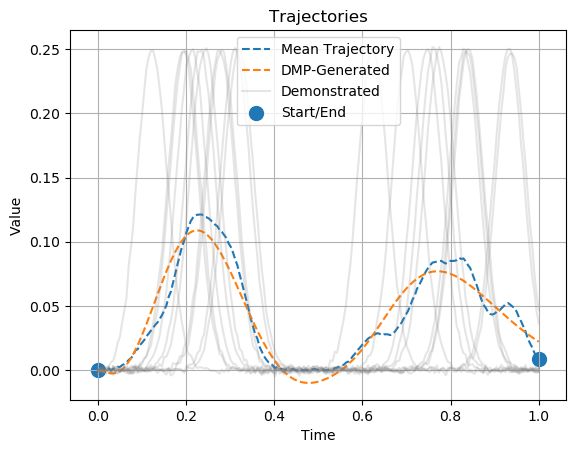

In [15]:
d = deepcopy(d_)
mean_y_np = torch.mean(y, axis=0).numpy()
x_np = x[0, :, 0].numpy()
d.imitate(x_np, mean_y_np)
sy, ey = mean_y_np[0], mean_y_np[-1]
d.configure(start_y=sy, goal_y=ey)

p = plt.plot(x_np, mean_y_np, label='Mean Trajectory', linestyle='--')
plt.scatter([0, 1], [sy, ey], color=p[0].get_color(), s=100, label='Start/End')

t, traj1 = d.open_loop()
p = plt.plot(t, traj1.squeeze(), label='DMP-Generated', linestyle='--')

for traj in range(num_trajs):
    label = 'Demonstrated' if traj==0 else ''
    plt.plot(x[traj], y[traj], 'gray', label=label, alpha=0.2)

plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.grid()
plt.title('Trajectories')

Text(0.5, 1.0, 'Trajectories')

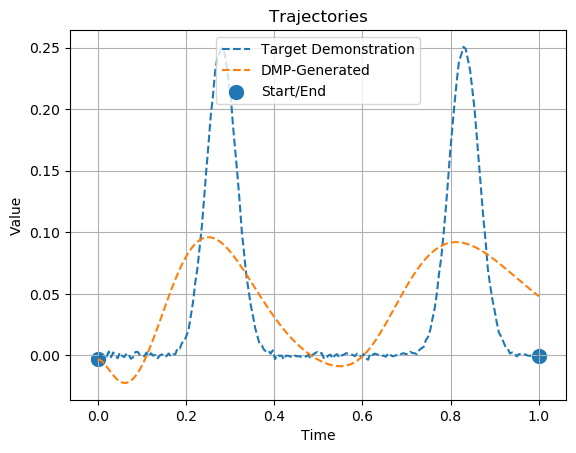

In [18]:
d = deepcopy(d_)

target_y_ind = 0

y_np = y[target_y_ind].numpy()
x_np = x[0, :, 0].numpy()
d.imitate(x_np, y_np)
sy, ey = y_np[0], y_np[-1]
d.configure(start_y=sy, goal_y=ey)

p = plt.plot(x_np, y_np, label='Target Demonstration', linestyle='--')
plt.scatter([0, 1], [sy, ey], color=p[0].get_color(), s=100, label='Start/End')

t, traj1 = d.open_loop()
p = plt.plot(t, traj1.squeeze(), label='DMP-Generated', linestyle='--')

# for traj in range(num_trajs):
#     label = 'Demonstrated' if traj==0 else ''
#     plt.plot(x[traj], y[traj], 'gray', label=label, alpha=0.2)

plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.grid()
plt.title('Trajectories')

Text(0.5, 1.0, 'Trajectories')

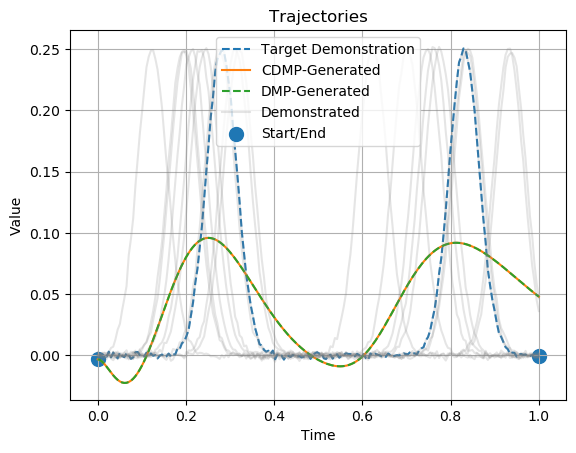

In [19]:
d = deepcopy(d_)

target_y_ind = 0

y_np = y[target_y_ind].numpy()
x_np = x[0, :, 0].numpy()
d.imitate(x_np, y_np)
sy, ey = y_np[0], y_np[-1]
d.configure(start_y=sy, goal_y=ey)

p = plt.plot(x_np, y_np, label='Target Demonstration', linestyle='--')
plt.scatter([0, 1], [sy, ey], color=p[0].get_color(), s=100, label='Start/End')


set_model(cnmp)

t, traj2 = d.open_loop()
plt.plot(t, traj2.squeeze(), label='CDMP-Generated', linestyle='-')
p = plt.plot(t, traj1.squeeze(), label='DMP-Generated', linestyle='--')

for traj in range(num_trajs):
    label = 'Demonstrated' if traj==0 else ''
    plt.plot(x[0], y[traj], 'gray', label=label, alpha=0.2)

plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.grid()
plt.title('Trajectories')